In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from polyvore_dataset_name import CategoryDataset, collate_fn
from sklearn import metrics
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import resnet
from model import SigmoidC
%matplotlib inline

# Dataloader
img_size = 224
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((img_size, img_size)),
        torchvision.transforms.ToTensor(),
    ]
)
train_dataset = CategoryDataset(
    root_dir="/home/wangx/datasets/polyvore/images/",
    transform=transform,
    use_mean_img=True,
    data_file="train_no_dup_with_category_3more_name.json")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataset = CategoryDataset(
    root_dir="/home/wangx/datasets/polyvore/images/",
    transform=transform,
    use_mean_img=True,
    data_file="valid_no_dup_with_category_3more_name.json"
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_dataset = CategoryDataset(
    root_dir="/home/wangx/datasets/polyvore/images/",
    transform=transform,
    use_mean_img=True,
    data_file="test_no_dup_with_category_3more_name.json",
    neg_samples=False
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [2]:
# Model!!!!!!!!!!!
class CompatModel(nn.Module):
    def __init__(self, embed_size, need_rep=False):
        """Load the pretrained CNN and replace top fc layer."""
        super(CompatModel, self).__init__()
        cnn = resnet.resnet50(pretrained=True, need_rep=need_rep)
        cnn.fc = nn.Linear(cnn.fc.in_features, embed_size)
        self.need_rep = need_rep
        self.cnn = cnn
        self.bn = nn.BatchNorm1d(25)
        self.fc1 = nn.Linear(25, 25)
        self.fc2 = nn.Linear(25, 1)
        self.sigmoid = SigmoidC()

        nn.init.xavier_uniform_(cnn.fc.weight)
        nn.init.constant_(cnn.fc.bias, 0)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)

        self.masks = nn.Embedding(embed_size, embed_size)
        self.masks.weight.data.normal_(0.9, 0.7)

    def forward(self, images):
        """Extract feature vectors from input images."""
        batch_size = images.shape[0]
        item_num = 5
        images = torch.reshape(images, (-1, 3, img_size, img_size))
        if self.need_rep:
            features, rep = self.cnn(images)
        else:
            features = self.cnn(images)
        features = features.reshape(batch_size, item_num, -1)  # (32, 5, 1000)

        # Type specified representation
        masked = []
        masks = []
        for i in range(item_num):
            mask = F.relu(self.masks(torch.tensor(i).to(device)))
            masks.append(mask)
            masked.append(mask * features[:, i, :])
        masked = torch.stack(masked, dim=1)
        masks = torch.stack(masks, dim=0)
        
        # Non-local like matmul
        cross = torch.matmul(masked, masked.transpose(1, 2))  # (32, 5, 5)
        cross = self.bn(cross.view(batch_size, -1))

        out = F.relu(self.fc1(cross), inplace=True)
        out = self.sigmoid(self.fc2(out))
        if self.need_rep:
            return out, features, masks, rep
        else:
            return out, features, masks

In [3]:
device = torch.device("cuda:0")

iterator = iter(test_loader)
next(iterator)
batch = next(iterator)
lengths, images, names, offsets, set_ids, labels, is_compat = batch

In [4]:
is_compat

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [58]:
# Select one outfit
select = 10
x = images[select].to(device)
x = x.unsqueeze(0)
x.requires_grad = True

# Upload Images

Run the following 2 cells, you can upload images locally. 

Otherwise, skip the following 2 cells.

0 upper


FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

1 bottom


FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

2 shoe


FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

3 bag


FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

4 accessory


FileUploadWidget(label='Browse', _dom_classes=('widget_item', 'btn-group'))

Uploaded `raw0.png` (55.26 kB)


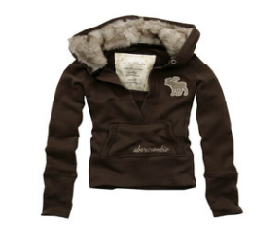

Uploaded `raw1.png` (54.45 kB)


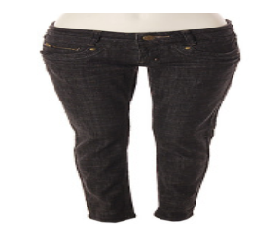

Uploaded `raw2.png` (63.86 kB)


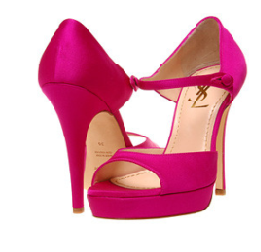

Uploaded `raw3.png` (49.85 kB)


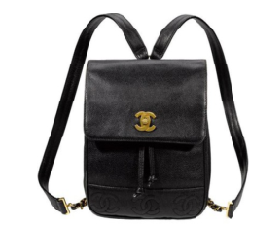

Uploaded `raw4.png` (47.79 kB)


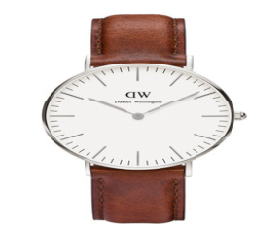

In [302]:
from IPython.display import display
import fileupload
from PIL import Image
import io

node_names = {0:'upper', 1:'bottom', 2:'shoe', 3:'bag', 4:'accessory'}
uploaders = [fileupload.FileUploadWidget() for _ in range(5)]

def _handle_upload(change):
    w = change['owner']
    print('Uploaded `{}` ({:.2f} kB)'.format(
        w.filename, len(w.data) / 2**10))
    img = Image.open(io.BytesIO(w.data))
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

for i, uploader in enumerate(uploaders):
    uploader.observe(_handle_upload, names='data')
    print(i, node_names[i])
    display(uploader)

In [284]:
from scipy.misc import imresize

datas = [u.data for u in uploaders]
imgs = []
for data in datas:
    img = Image.open(io.BytesIO(data)).convert('RGB')
    img = transform(img)
    imgs.append(img)

imgs = torch.stack(imgs)

is_compat = 0
x = imgs.unsqueeze(0).to(device)
x.requires_grad=True

# Visualize

In [59]:
# Get guided backpropagation

def guided_backprop(img=x):
    """
    Return:
        gradient: gradient map with the same size as img.
    """
    gradient = None
    model = CompatModel(embed_size=1000).to(device)
    model.load_state_dict(torch.load('./model.pth'))
    model.eval()
    
    # Register hook to the first layer
    def hook_function(module, grad_in, grad_out):
        nonlocal gradient
        gradient = grad_in[0]

    first_layer = list(model.modules())[2]
    first_layer.register_backward_hook(hook_function)

    #Updates relu activation functions so that it only returns positive gradients
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, changes it to zero
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
    # Loop through layers, hook up ReLUs with relu_hook_function
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.register_backward_hook(relu_hook_function)

    # Forward
    out, _, _ = model(img)
    one_hot = torch.FloatTensor([[1]]).to(device)

    # Backward
    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)
    
    return gradient.cpu().data.numpy()

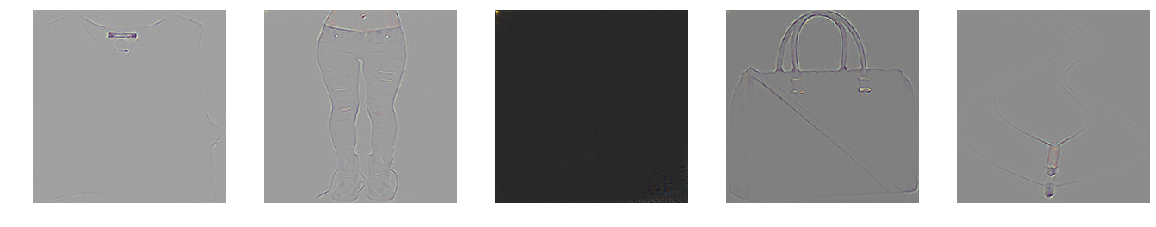

In [60]:
# Visualize Guided_backprop
grads = guided_backprop()

fig = plt.figure(figsize=(20,4))
for idx in range(grads.shape[0]):
    grad_map = grads[idx]
    grad_map = grad_map - grad_map.min()
    grad_map /= grad_map.max()
    grad_map = np.uint8(grad_map * 255).transpose(1, 2, 0)
    plt.subplot(1, grads.shape[0], idx+1)
    plt.imshow(grad_map)
    plt.axis('off')
plt.show()

In [61]:
# Grad-CAM
def grad_cam(img=x, target_layer='cnn.layer4.2.bn3'):
    target_layer = target_layer
    feat_map = None
    grad = None 
    model = CompatModel(embed_size=1000).to(device)
    model.load_state_dict(torch.load('./model.pth'))
    model.eval()
    
    # Register hook for feature map
    def func_f(module, input, output):
        nonlocal feat_map
        feat_map = output.detach()

    # Register hook for gradients on target layer
    def func_b(module, grad_in, grad_out):
        nonlocal grad
        grad = grad_out[0].detach()

    for m in model.named_modules():
        if m[0] == target_layer:
            m[1].register_forward_hook(func_f)
            m[1].register_backward_hook(func_b)
            
    # Forward
    out, _, _ = model(img)
    one_hot = torch.FloatTensor([[1]]).to(device)

    # Backward
    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)
    
    return grad, feat_map, out.item()

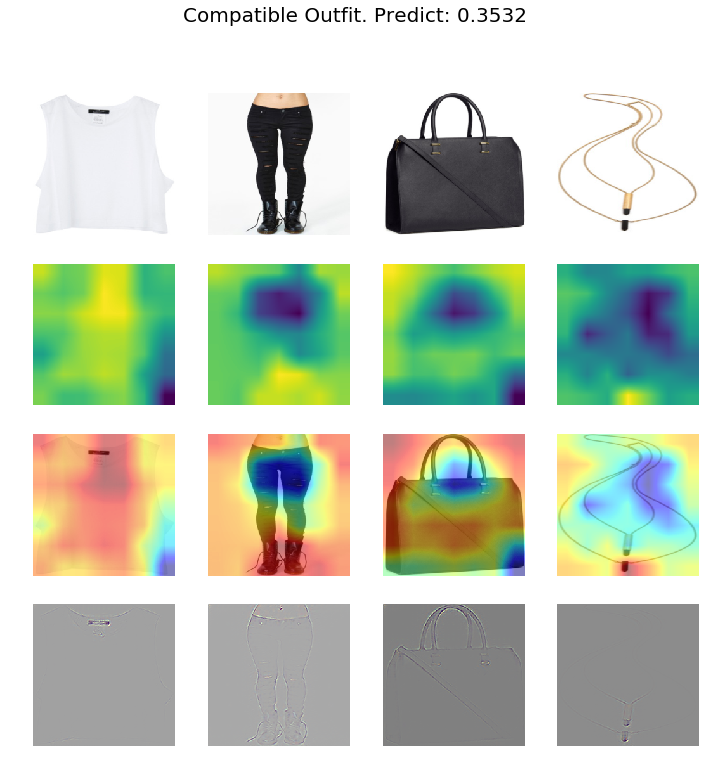

In [62]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

grad, feat_map, out = grad_cam()

num_of_col = len(list(filter(lambda x:'mean' not in x, labels[select])))
num_of_row = 4 # raw, cam, raw+cam, camgrad
fig = plt.figure(figsize=(num_of_col*3, num_of_row*3))
col = 0
for idx in range(grad.shape[0]):
    if 'mean' in labels[select][idx]:
        continue
    else:
        col += 1
    
    # raw
    plt.subplot(num_of_row, num_of_col, 0*num_of_col+col)
    raw_image = x[0][idx].cpu().data.numpy().transpose((1, 2, 0)) * 255
    raw_image = raw_image[..., :3]
    plt.imshow(np.uint8(raw_image))
    plt.axis('off')

    # cam
    plt.subplot(num_of_row, num_of_col, 1*num_of_col+col)
    guided_gradients = grad[idx].cpu().data.numpy()
    # Get convolution outputs
    target = feat_map[idx].cpu().data.numpy()
    # Get weights from gradients
    weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
    # Create empty numpy array for cam
    cam = np.ones(target.shape[1:], dtype=np.float32)
    # Multiply each weight with its conv output and then, sum
    for i, w in enumerate(weights):
        cam += w * target[i, :, :]
    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    plt.imshow(cam)
    plt.axis('off')

    # raw+cam
    plt.subplot(num_of_row, num_of_col, 2*num_of_col+col)
    norm = Normalize(vmin=cam.min(), vmax=cam.max())
    heatmap = cm.jet(norm(cam))[..., :3]
    composed = np.uint8(heatmap * 255) + raw_image
    composed = composed / composed.max() * 255.
    plt.imshow(np.uint8(composed))
    plt.axis('off')

    # guided-grad-cam
    plt.subplot(num_of_row, num_of_col, 3*num_of_col+col)
    guided_cam = np.multiply(grads[idx], cam)
    guided_cam = guided_cam - guided_cam.min()
    guided_cam /= guided_cam.max()
    guided_cam = np.uint8(guided_cam * 255).transpose(1, 2, 0)
    plt.imshow(guided_cam)
    plt.axis('off')
        
plt.suptitle('Compatible Outfit. Predict: {:.4f}'.format(out), fontsize=20)
plt.savefig(fname="{}.png".format(select))
plt.show()

# Compute Gradient on Relationship Matrix

Diagnose for incompatible outfit.

In [17]:
def defect_detect(img=x):
    model = CompatModel(embed_size=1000).to(device)
    model.load_state_dict(torch.load('./model.pth'))
    model.eval()

    # Register hook for relation matrix
    relation = None
    def func_r(module, grad_in, grad_out):
        nonlocal relation
        relation = grad_in[1].detach()

    for name, module in model.named_modules():
        if name == 'fc1':
            module.register_backward_hook(func_r)

    # Forward
    out, _, _ = model(img)
    one_hot = torch.FloatTensor([[-1]]).to(device)

    # Backward
    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)
    
    relation = F.normalize(relation)
    relation = relation.reshape(5, 5).abs()
    relation = torch.triu((relation + relation.transpose(0, 1)) / 2)
    relation = relation.cpu().data.numpy()
    relation = np.round(relation, decimals=2)
    return relation

In [20]:
def visualize_adjacency(A):
    """Visualize an adjacency matrix.
    
    Args:
        A (numpy.array|torch.Tensor): upper left triangle matrix
    """
    fig = plt.figure(figsize=(10, 10))
    node_names = {0:'Top', 1:'bottom', 2:'shoe', 3:'bag', 4:'accssory'}
    # Extract weights
    if isinstance(A, torch.Tensor):
        A = A.cpu().data.numpy()
    diag = A.diagonal()
    bad_item = node_names[diag.argmax()]
    A = np.triu(A, k=1)
    indices = A.nonzero()
    weights = A[indices[0], indices[1]]
    
    # Generate graph
    G = nx.Graph()
    for i, j, weight in zip(*indices, weights):
        G.add_edge(node_names[i], node_names[j], weight=weight)
        
    sorted_edges = sorted(G.edges(data=True), key=lambda x:x[2]['weight'], reverse=True)
        
    elarge=[(u,v) for (u,v,d) in sorted_edges[:3]]
    esmall=[(u,v) for (u,v,d) in sorted_edges[3:]]
    print("I have 3 suggestions...")
    print(elarge)
    
    pos=nx.spring_layout(G) # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, nodelist=[bad_item], node_size=1500, node_color='red')
    nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes() if n != bad_item], node_size=1000, node_color='yellow')
    
    # edges
    nx.draw_networkx_edges(G,pos,edgelist=elarge, width=6, alpha=0.5, edge_color='red',style='dashed')
    nx.draw_networkx_edges(G,pos,edgelist=esmall, edge_color='yellow', alpha=0.5, width=6)
    
    # labels
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_labels(G,pos, font_size=24, font_family='sans-serif')
    nx.draw_networkx_edge_labels(G, pos, font_size=24, font_family='sans-serif', edge_labels=labels)
    
    plt.axis('off')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.savefig('network.png', bbox_inches='tight', pad_inches = 0)
    plt.show() # display

I have 3 suggestions...
[('Top', 'bottom'), ('shoe', 'bag'), ('bottom', 'shoe')]


/home/wangx/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


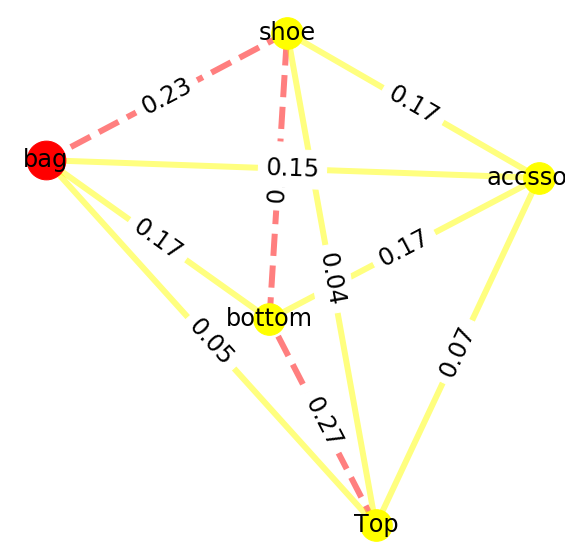

In [21]:
relation = defect_detect()
visualize_adjacency(relation)